<a href="https://colab.research.google.com/github/DannMacias/ztm_pytorch/blob/main/04_PyTorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> 04 PyTorch Custom Datasets </b>

A **custom dataset** is a collection of data relating to a specific problem you're working on.

We're going to be using our own dataset of pizza, steak and sushi images.

In [ ]:
import torch
from torch import nn

torch.__version__

'1.12.1+cu113'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get the data

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). 

Food101 is a popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75, 750 train and 25,250 test).

Instead of 101 food classes though, we're going to star with 3 classes: pizza, steak and sushi; and a random 10% of the images.

If you'd like to see where the data came from you see the following resources:
* Original [Foo101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/);
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data for this notebook;
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook used for D. Bourke to format the Food101 dataset to use for this notebook;
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# 2. Data preparation

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled woth a particulas class name.

For example:

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

We can inspect what's in our data directory by writting a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`.

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path retuning its contents.

  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdirectories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


It looks like we've got about 75 images per training class and 25 images per testing class.

Let's setup our training and testing paths.

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###Visualize and image

1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using `pathlib.Path.parent.stem`.
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/test/steak/894825.jpg
Image class: steak
Image height: 512
Image width: 512


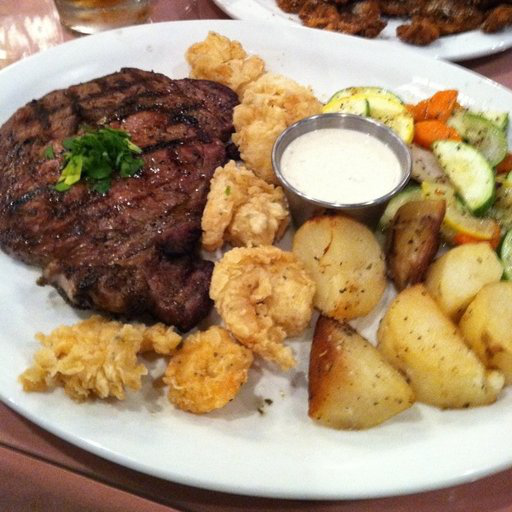

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # (*) means any combination

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
# (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first.

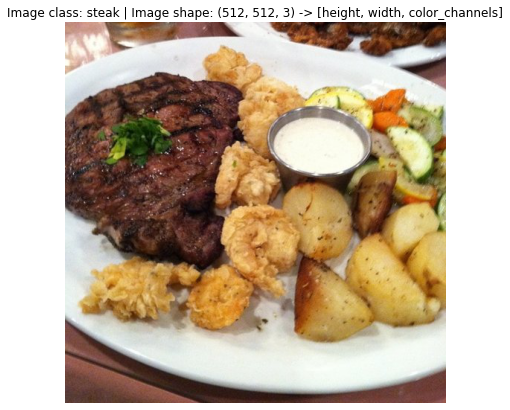

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

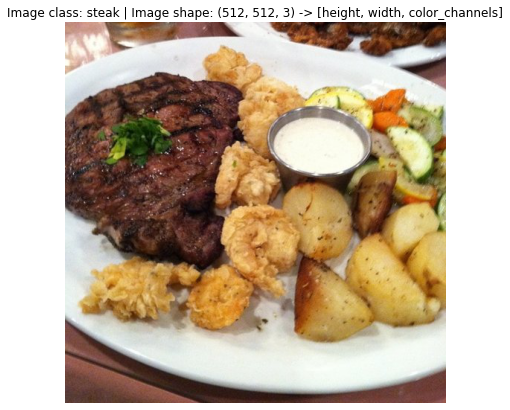

In [ ]:
# Note: You can pass a PIL image to matplotlib
# Is not neccesary convert img to a numpy array
# See documentation: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html
plt.figure(figsize = (10, 7))
plt.imshow(img)
# For image shape, we need to convert the image to a NumPy array
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

#3. Transforming data

Before we can use our image data with PyTorch we need to:
1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Datasets` and `DataLoader` for short.

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.

In [ ]:
# Import torchvision datsets and tranforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn) purpose.

**Series of transformations:**
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512 X 512 to 64 X 64).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using `torchvision.transforms.Compose()`

In [ ]:
# Make tranforms for image
data_transform = transforms.Compose([
    # Resize image to 64X64
    transforms.Resize(size = (64, 64)),
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5), # p = probability of flip
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # converts pixel values from 0 to 255 to be between 0.0 and 1.0
])

We've got a composition of transforms, let's write a function to try them out on various images.

In [ ]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
  """
  Plots a series of random images from image_paths

  Will open n imahe paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
    image_paths (list): List of target image paths.
    transform (PyTorch Transform): Transforms to apply to images.
    n (int, optional): Number of images to plot. Default to 3.
    seed (int, optional): Random seed for the random generator. Default to 42
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlin is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

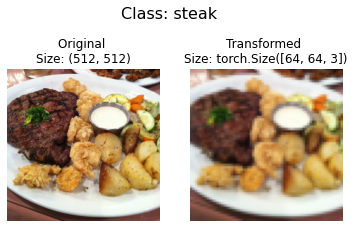

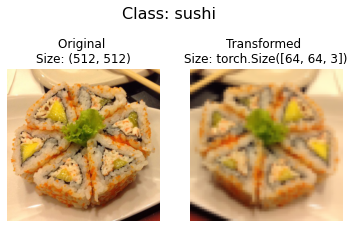

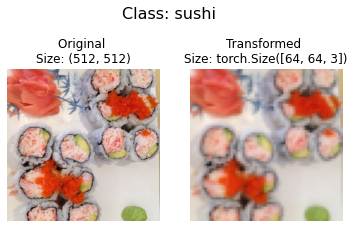

In [ ]:
plot_transformed_images(image_path_list,
                        transform = data_transform,
                        n = 3)

We've now got a way to convert our images to tensors using `torchvision.transforms`.

We also manipulate their size and orientation (some models prefer images of different sizes and shapes)

Generally, the larger the shape of the image, the more information a model can recover. However, the tradeoff is that more pixels requieres more computations.

#4. Option 1: Loading image data using `ImageFolder`

Time to turn our image into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir, # target folder images
                                  transform = data_transform, # transforms to perform on data
                                  target_transform = None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Let's inspect them ny checking out the `classes` and `class_to_idx` attributes as well as the lenghts of our training and test sets.

In [ ]:
# Get classes names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lenghts
len(train_data), len(test_data)

(225, 75)

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an interger relating to a specific class (as referenced by the `class_to_idx` attribute).

To plot the image using matplotlib, we'll first have to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the formar `CHW` but matplotlib prefers `HWC`.

Original shape: torch.Size([3, 64, 64]) -> [CHW]
Image permute shape: torch.Size([64, 64, 3]) -> [HWC]


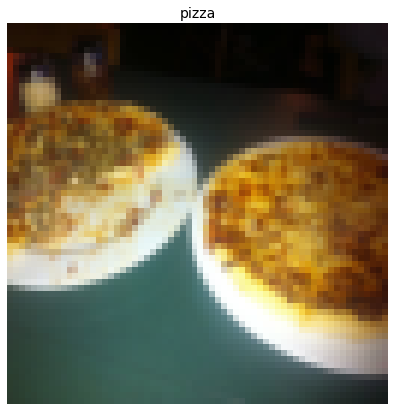

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [CHW]")
print(f"Image permute shape: {img_permute.shape} -> [HWC]")

# Plot the image
plt.figure(figsize = (10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize = 14);

Notice the image is now more pixeled (less quality). This is due to it being resized from `512x512` to `64x64` pixels.

### Turn loaded images into `DataLoader`

Turning our `Dataset` into `DataLoader` (using `torch.utils.data.DataLoader`) makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size = 1` and `num_workers = 1`.

**WHAT'S `num_workers`?**

It defines how many subprocesses will be created to load your data.
* The higher value, the more compute power PyTorch will use to load your data.
* Set the total numbers of CPU's on your machine via Python's `os.cpu_count()`.


In [ ]:
# Turn tran and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 1,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fdb5e9b8b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdb5e9b2c10>)

In [ ]:
# Check the shapes
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look another option to load images (or almost any other kind of data).

# 5. Option 2: Loading image data with custom `Dataset`

What if a pre-built `Dataset` creator like `torchvision.datasets.ImageFolder()` didn't exist? Or one for yout specific problem didn't exist?

Well, you could build your own.

|**Pros of creating a custom`Dataset`**|**Cons of creating a custom `Dataset`**|
|-|-|
|Can create a `Dataset` out of almost anything|Sometimes it will work|
|Not limited to PyTorch pre-built `Dataset` functions|Writting more code, prone to error or performed issues|

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:
* Python's `os` for dealing with directories.
* Python's `pathlib` for dealing with filepaths.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom Dataset.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's typing module to add type hints to our code.

In [ ]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

1. Get the class names using `os.scandir()` to traverse a target directory.
2. Raise an error if the class names areb't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.


In [ ]:
# Setup path for target directory
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Class names found: ['pizza', 'steak', 'sushi']


In [ ]:
# Make a function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Find the class folder names in a target directory.

  Assumes target directory is in standard image classificacion format.

  Args:
    directory (str): target directory to load classnames from.
  
  Returns:
    Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
  
  Example:
    find_class("food_image/train")
    >>> (["class_1", "class_2"], {"class_1": 0, ...})
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if classes names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  
  # 3. Create a dictionary of index labels (numerical encoding)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx


In [ ]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

We're ready to build our own `Dataset`.

We'll build one to replicate the functionally of `torchvision.datasets.ImageFolder()`

1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `path`, `transform`, `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or `torchvision.io`.
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [ ]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize with a targ_dir and transform (optional) parameter
  def __init__(self, targ_dir: str, transform = None) -> None:

    # 3. Create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Make function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len__() method (optional but recommended)
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, Y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if neccesary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, Y)
    else:
      return img, class_idx # return data, label (X, Y)
  

Now we're written our custom `Dataset`, we could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on.

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

# Don't augment test data only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fdb5e97fa50>,
 <__main__.ImageFolderCustom at 0x7fdb5ec158d0>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data_custom)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### Create a function to display random images

Let's creare a helper function called `display_random_images()` that help us visualize images in our `Dataset`'s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed.
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HCW` so we can plot them.

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  
  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  # 5. Setup plot
  plt.figure(figsize = (16, 10))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust image tensor sahpe for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

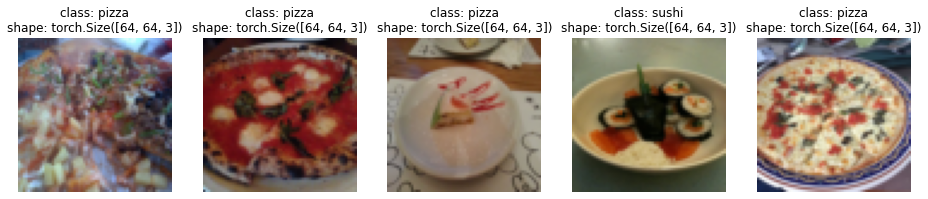

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


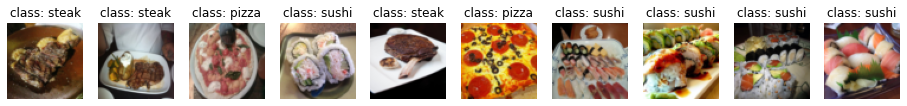

In [ ]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n= 12,
                      classes = class_names,
                      seed =None)

### Turn custom loaded images into `DataLoader`'s

We've got a way to turn our raw images into `Dataset`'s (features mapped to labels or `X`'s mapped to `y`'s) through our `ImageFolderCustom` class.

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = 1,
                                     num_workers = 0,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = 1,
                                    num_workers = 0,
                                    shuffle = False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fdb5dc91190>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdb5dc914d0>)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [N, C, H, W]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [N, C, H, W]
Label shape: torch.Size([1])


#6. Other forms of transforms (data augmentation)

The purpose of transforms is to alter you images in some way. That may be turning your images into a tensor, or cropping it randomly erasing a portion or randomly rotating them.

**Data augmentation** - is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully resutls in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on image using `torchvision.transforms` in PyTorch's [illustration of Transforms example](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms).

> Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins = 31`.
* It defines how much of range an intensity will be picked to apply a certain transform.
* `0` being no range and `31` being the maximun range (highest chance for highest intensity).

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31), # how intense
    transforms.ToTensor()
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

> ❗ **Note**: You usually **don't perform data augmentation on the test set**. The idea of data augmentation is to *artificially* increase the diversity of the training set to better predict on the testing set.
>
> However, you do need to make sure your test set images are transformed to tensors. We size the test mages to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Let's test our data augmentation out. 

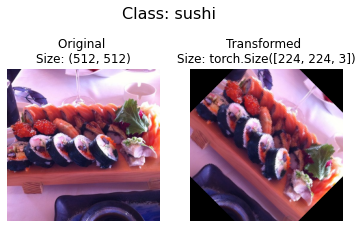

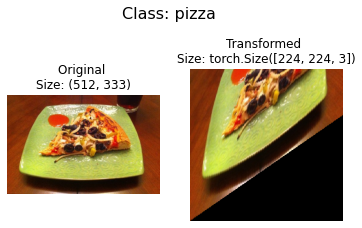

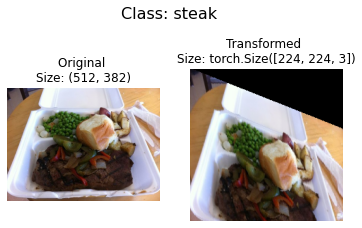

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(image_paths = image_path_list,
                        transform = train_transforms,
                        n = 3,
                        seed = None)

#7. Model 0: TinyVGG without data augmentation

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

### Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()`.
2. Them into a `DataLoader` using `torch.utils.data.DataLoader()`.
  * We'll set the `batch_size = 32` and `num_workers` to as many CPUs on our machine.

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle = False)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x7fdb62a8f490>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdb62a8f4d0>)

### Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features = hidden_units*16*16,
                  out_features = output_shape)  
    )
  
  def forward(self, x: torch.Tensor):
    # No operator fusion (slor computing)
    # x = self.conv_block_1(x)
    # x = self.conv_block_2(x)
    # x = self.classifier(x)
    # Leverage the benefits of operator fusion (fast computing)
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels (3 for RGB)
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **Note**: One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
> 
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
> 
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
> 
> See [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html) by Horace.



### Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [ ]:
# 1. Get a batch of images and labes from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim = 0), label_batch[0]
print(f"Single image shape (Unsqueeze -> NCHW): {img_single.shape}\n")
print(f"Original image shape (Squeeze -> CHW): torch.Size([3, 64, 64])\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

# 4. Print out what's happening
# Convert model logits -> pred probs (softmax) -> pred label (argmax)
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim = 1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim = 1), dim = 1)}\n")
print(f"Actual label:\n{label_single}")


Single image shape (Unsqueeze -> NCHW): torch.Size([1, 3, 64, 64])

Original image shape (Squeeze -> CHW): torch.Size([3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0352]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


You'll probably notice the predictions are often wrong.

This is to be expected because the model hasn't been trained yet and it's essentially guessing using random weights.

### Use `torchinfo` to get an idea of the shapes going through our model

A helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

> `torchinfo` provides information complementary to what is provided by `print(your_model)` in PyTorch.

**How to use**

```
from torchinfo import summary

model = ConvNet()
batch_size = 16
summary(model, input_size=(batch_size, 1, 28, 28))
```
`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

In [ ]:
# Installing torchinfro
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### Creating train and test loop functions

We're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1, and 2 together for a given number of epochs and returns a results dictionary.

Because we're dealing with batches in the `DataLoader`'s, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust at the end before we return them.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, Y) in enumerate(dataloader):
    # Send data to target device
    X, Y = X.to(device), Y.to(device)

    # 1. Forward pass
    Y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(Y_pred, Y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    Y_pred_class = torch.argmax(torch.softmax(Y_pred, dim = 1), dim = 1)
    train_acc += (Y_pred_class == Y).sum().item()/len(Y_pred)
    
  # Adjust metrics to get average loss and accuracy per bathc
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, Y) in enumerate(dataloader):
      # Send data to target device
      X, Y = X.to(device), Y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumalte loss
      loss = loss_fn(test_pred_logits, Y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += (test_pred_labels == Y).sum().item()/len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

This function will train the model as well as evaluate it.

1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values.
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metric each epoch.
6. Return the filled.

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` (`tqdm` is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # 2. Create empty resutls dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer)
    
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn)
    
    # 4. Print out what's happening
    print(
        f"Epoch: {epoch + 1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### Train and evaluate Model 0

We'll train our model for **5 epochs**.

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a lerning rate of `1e-3` respectively.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Recrete an instance of TinyVGG
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2314 | train_acc: 0.2500 | test_loss: 1.2111 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1010 | train_acc: 0.4141 | test_loss: 1.1047 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1017 | train_acc: 0.2930 | test_loss: 1.1075 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0944 | train_acc: 0.4141 | test_loss: 1.1108 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0998 | train_acc: 0.2930 | test_loss: 1.1172 | test_acc: 0.1979
Total training time: 16.953 seconds


Hmm... It looks like our model performed pretty poorly. But that's okay for now, we'll keep persevering.

### Plot the loss curves of Model 0



In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plot training curves of a results dictionary

  Args:
    results (dict): dictionary containing list of values, e.g:
    {"train_loss": [...],
    "train_acc": [...],
    "test_loss": [...],
    "test_acc": [...]}
  """

  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup plot
  plt.figure(figsize = (15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

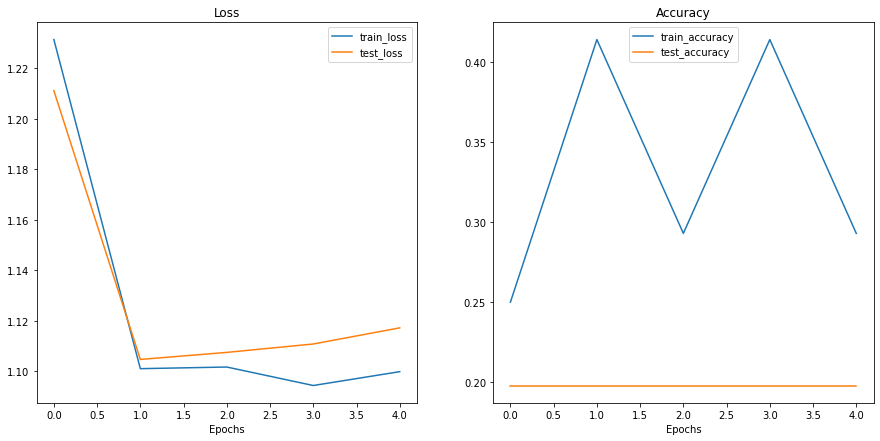

In [ ]:
plot_loss_curves(model_0_results)

#8. What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

> If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

> The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

#9. Model 1: TinyVGG with data augmentation

We'll compose a training transform to include `transforms.TrivialAugmentWide()` as welll as resize and turn our images into tensors.

### Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augmented = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

# Create testing transforms
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### Create train and test `Dataset`'s and `DataLoader`'s

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial_augmented)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

We'll make `DataLoader`'s with a `batch_size = 32` and with `num_workers` set to the number of CPUs available on our machine (we can get this using Python's `os.cpu_count()`.

In [ ]:
# Turn Datasets into DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS,
                                        shuffle = True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle = False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7fdb541cc150>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdb5e022390>)

### Construct and train Model 1

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

We'll use the same setup as `model_0` with only the `train_dataloader` parameter varying:
* Train for 5 epochs.
* Use `torch.nn.CrossEntropyLoss()` as the loss function (multi-class classification)
* Use `torch.optim.Adam()` with `lr = 0.01` as the learning rate as the optimizer.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.01)

# Start the timer
from timeit import default_timer
start_time = timer()

# Train model_1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1802 | train_acc: 0.2617 | test_loss: 1.2151 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1116 | train_acc: 0.4258 | test_loss: 1.1048 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0915 | train_acc: 0.4258 | test_loss: 1.1081 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1031 | train_acc: 0.3047 | test_loss: 1.1127 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0886 | train_acc: 0.4258 | test_loss: 1.1193 | test_acc: 0.2604
Total training time: 11.821 seconds


### Plot the loss curves of Model 1

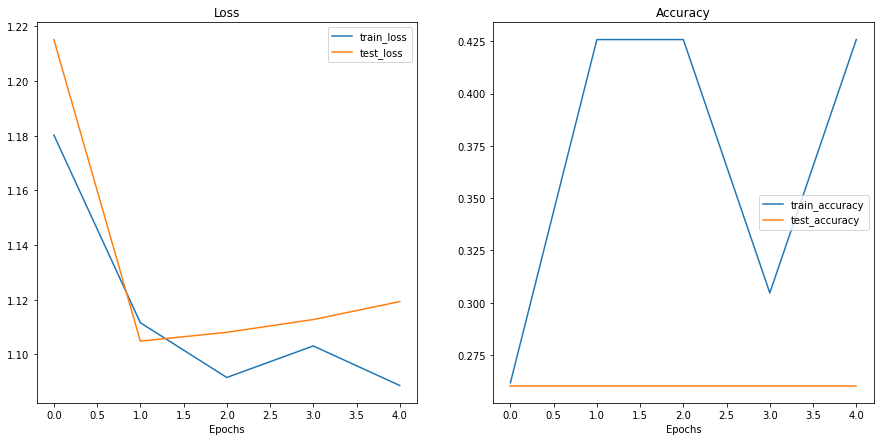

In [ ]:
plot_loss_curves(model_1_results)

#10. Compare model results

Even though our models performing quite porrly, we can still write code to compare them.

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.231378,0.250000,1.211133,0.197917
1,1.101034,0.414062,1.104692,0.197917
2,1.101683,0.292969,1.107484,0.197917
3,1.094366,0.414062,1.110802,0.197917
4,1.099846,0.292969,1.117199,0.197917


And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

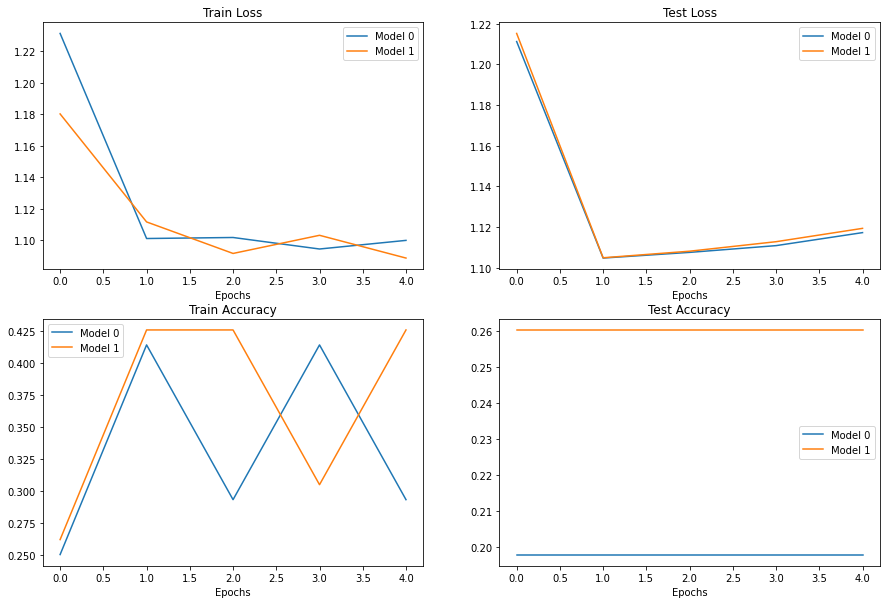

In [ ]:
# Setup a plot
plt.figure(figsize = (15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

#11. Make a prediction on a custom image

We can load an image and then **preprocess it in a way that matches the type of data our model was trained on**.

In other words, we'll have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

Let's start by downloading a custom image using Python's `request` module.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download")

### Loading in a custom image with PyTorch

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in [`torchvision.io`](https://pytorch.org/vision/stable/io.html).

Since we want to load in an image, we'll use [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype `uint8` in range `[0, 255]`.

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

Looks like our image is in tensor format, however, **is this image format compatible with our model?**

Our custom_image tensor is of datatype `torch.uint8` and its values are between `[0, 255]`.

But our model takes image tensors of datatype `torch.float32` and with values between `[0, 1]`.

> So before we use our custom image with our model, we'll need to convert it to the same format as the data our model is trained on.
>
> If we don't do this, our model will error.

If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

```
RuntimeError: Input type (torch.cuda.ByteTensor) and weight type 
(torch.cuda.FloatTensor) should be the same
```

Let's fix this by converting our custom image to the same datatype as what our model was trained on (`torch.float32`).

In [ ]:
# Load custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### Predicting on custom image with trained PyTorch model

Our model was trained on images with shape `[3, 64, 64]`, whereas our custom image is currently `[3, 4032, 3024]`.

Let's plot the image with `matplotlib` to make sure it looks okay, remember we'll have to `permute` the dimensions from `CHW` to `HWC` to suit matplotlib's requirements.

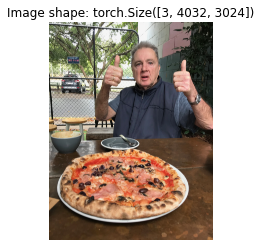

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

**How could we get our image to be the same size as the images our model was trained on?**

One way to do so is with `torchvision.transforms.Resize()`.

In [ ]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


There's one dimension we forgot about.

**The batch size**.

Our model expects image tensors with a batch size dimension at the start (`NCHW` where `N` is the batch size).

Except our custom image is currently only `CHW`.

We can add a batch size dimension using `torch.unsqueeze(dim = 0)` to add an extra dimension our image and finally make a prediction.

Essentially we'll be telling our model to predict on a single image (an image with a `batch_size` of 1).

In [ ]:
model_1.eval()
with torch.inference_mode():
  # Add an extra dimension to image
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim = 0)

   # Print out different shapes
  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

  # Make a prediction on image with an extra dimension
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim = 0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


> **Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:
> 
> 1. **Wrong datatypes** - our model expects `torch.float32` where our original custom image was `uint8`.
> 2. **Wrong device** - our model was on the target `device` (in our case, the GPU) whereas our target data hadn't been moved to the target `device` yet.
> 3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.
>
> Keep in mind, these errors aren't just for predicting on custom images.
>
> They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.

In [ ]:
custom_image_pred

tensor([[ 0.0909, -0.0170, -0.0679]])

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [ ]:
# Print out predictions logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilites (softmax)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
print(f"Prediction probabilites: {custom_image_pred_probs}")

# Convert prediction probabilites -> prediction labels (argmax)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim = 1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.0909, -0.0170, -0.0679]])
Prediction probabilites: tensor([[0.3635, 0.3263, 0.3101]])
Prediction label: tensor([0])


In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

It looks like the model gets the prediction right, even though it was performing poorly based on our evaluation metrics.

But if we check the `custom_image_pred_probs`, we'll notice that the model gives almost equal weight (the values are similar) to every class.

In [ ]:
# The values of the prediction probabilites are quite similar
custom_image_pred_probs

tensor([[0.3635, 0.3263, 0.3101]])

> Having prediction probabilities this similar could mean a couple of things:
> 
> 1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
>
> 2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

Our case is number 2, since our model is poorly trained, it is basically guessing the prediction.

### Putting custom image prediction togther: building a function

Let's make a function that:

1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device: torch.device = device):
  """
  Makes a prediction on a target image and plots the image with its prediction.
  """

  # 1. Load an image and convert the tensor values to float32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255

  # 3. Transform if neccesary
  if transform:
    target_image = transform(target_image)

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image
    target_image = target_image.unsqueeze(dim = 0)

    # Make a prediction and send it to the target device
    target_image_pred = model(target_image.to(device))

  # 6. Convert logits -> prediction probabilites
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  # 7. Convert prediction probabilites -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  # 8. Plot the image
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} |  Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

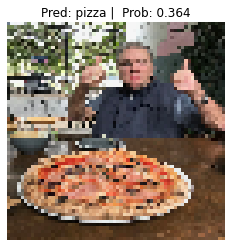

In [ ]:
# Pred on our custom image
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "01-steak-google.jpg"

with open(custom_image_path, "wb") as f:
  request = requests.get("https://natashaskitchen.com/wp-content/uploads/2020/03/Pan-Seared-Steak-4.jpg")
  print(f"Downloading {custom_image_path}...")
  f.write(request.content)

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.2078, 0.2118, 0.2118],
         [0.0118, 0.0118, 0.0118,  ..., 0.2039, 0.2078, 0.2078],
         [0.0118, 0.0118, 0.0118,  ..., 0.1961, 0.2000, 0.2000],
         ...,
         [0.0314, 0.0314, 0.0314,  ..., 0.3490, 0.3490, 0.3490],
         [0.0314, 0.0314, 0.0314,  ..., 0.3490, 0.3490, 0.3490],
         [0.0314, 0.0314, 0.0314,  ..., 0.3490, 0.3490, 0.3490]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.2275, 0.2314, 0.2314],
         [0.0118, 0.0118, 0.0118,  ..., 0.2235, 0.2275, 0.2275],
         [0.0118, 0.0118, 0.0118,  ..., 0.2157, 0.2196, 0.2196],
         ...,
         [0.0314, 0.0314, 0.0314,  ..., 0.4118, 0.4118, 0.4118],
         [0.0314, 0.0314, 0.0314,  ..., 0.4118, 0.4118, 0.4118],
         [0.0314, 0.0314, 0.0314,  ..., 0.4118, 0.4118, 0.4118]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.2431, 0.2471, 0.2471],
         [0.0118, 0.0118, 0.0118,  ..., 0.2392, 0.2431, 0.2431],
         [0.0118, 0.0118, 0.0118,  ..

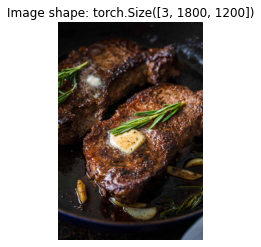

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

In [ ]:
model_1.eval()
with torch.inference_mode():
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

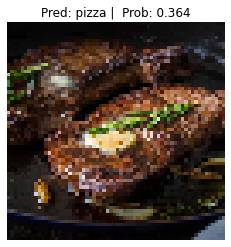

In [ ]:
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)